In [1]:
import SimpleITK as sitk

import sys; sys.path.append("../src/readii")
from process.images.crop import crop_and_resize_image_and_mask
from image_processing import displayImageSlice

from imgtools.io import read_dicom_series
from rich import print as rprint

from readii.loaders import loadRTSTRUCTSITK

from readii.image_processing import displayImageSlice

import matplotlib.pyplot as plt

import numpy as np

In [10]:
sample = "4D-Lung-113_HM10395_dcm"

match sample:
    case "RADCURE-0020_nifti":
        ct_path = "/Users/katyscott/Documents/READII-2-ROQC/readii-fmcib/archive/temp_complete_output/procdata/RADCURE/images/mit_outputs/0_RADCURE-0020/CT/CT.nii.gz"
        mask_path = "/Users/katyscott/Documents/READII-2-ROQC/readii-fmcib/archive/temp_complete_output/procdata/RADCURE/images/mit_outputs/0_RADCURE-0020/RTSTRUCT_CT/GTV.nii.gz"

        image = sitk.ReadImage(ct_path)
        mask = sitk.ReadImage(mask_path)

    case "RADCURE-0065_nifti":
        ct_path = "/Users/katyscott/Documents/READII-2-ROQC/readii-fmcib/archive/temp_complete_output/procdata/RADCURE/images/mit_outputs/5_RADCURE-0065/CT/CT.nii.gz"
        mask_path = "/Users/katyscott/Documents/READII-2-ROQC/readii-fmcib/archive/temp_complete_output/procdata/RADCURE/images/mit_outputs/5_RADCURE-0065/RTSTRUCT_CT/GTV.nii.gz"

        image = sitk.ReadImage(ct_path)
        mask = sitk.ReadImage(mask_path)
    
    case "4D-Lung-113_HM10395_dcm":
        image = read_dicom_series("../tests/4D-Lung/113_HM10395/11-26-1999-NA-p4-13296/1.000000-P4P113S303I10349 Gated 40.0B-29543")

        rois = loadRTSTRUCTSITK(rtstructPath = "../tests/4D-Lung/113_HM10395/11-26-1999-NA-p4-13296/1.000000-P4P113S303I10349 Gated 40.0B-47.35/1-1.dcm",
                                baseImageDirPath = "../tests/4D-Lung/113_HM10395/11-26-1999-NA-p4-13296/1.000000-P4P113S303I10349 Gated 40.0B-29543",
                                roiNames = "Tumor_c.*")
        mask = rois["Tumor_c40"]

    case "RADCURE-0020_dcm":
        image = read_dicom_series('/Users/katyscott/Documents/Data/RADCURE/RADCURE/RADCURE-0020/01-25-2011-NA-Research HNC Planning CT-86499/2.000000-NA-91320')
        rois = loadRTSTRUCTSITK(rtstructPath='/Users/katyscott/Documents/Data/RADCURE/RADCURE/RADCURE-0020/01-25-2011-NA-Research HNC Planning CT-86499/1.000000-NA-66221/1-1.dcm',
                                baseImageDirPath='/Users/katyscott/Documents/Data/RADCURE/RADCURE/RADCURE-0020/01-25-2011-NA-Research HNC Planning CT-86499/2.000000-NA-91320',
                                roiNames = "GTVp$")
        mask = rois["GTVp"]

    case "RADCURE-0065_dcm":
        image = read_dicom_series('/Users/katyscott/Documents/Data/RADCURE/RADCURE/RADCURE-0065/06-25-2002-NA-Research HNC Planning CT-77356/2.000000-Helical Axial-28086')
        rois = loadRTSTRUCTSITK(rtstructPath='/Users/katyscott/Documents/Data/RADCURE/RADCURE/RADCURE-0065/06-25-2002-NA-Research HNC Planning CT-77356/1.000000-NA-53232/1-1.dcm',
                                baseImageDirPath='/Users/katyscott/Documents/Data/RADCURE/RADCURE/RADCURE-0065/06-25-2002-NA-Research HNC Planning CT-77356/2.000000-Helical Axial-28086',
                                roiNames = "GTVp$")
        mask = rois["GTVp"]

    case "4D-Lung-114_HM10395_dcm":
        image = read_dicom_series('/Users/katyscott/Documents/Data/TCIA_TCGA_Datasets/4D-Lung/manifest-1701890860263/4D-Lung/114_HM10395/04-13-2000-NA-p4-15839/1.000000-P4P114S301I00007 Gated 40.0A-72633')
        rois = loadRTSTRUCTSITK(rtstructPath='/Users/katyscott/Documents/Data/TCIA_TCGA_Datasets/4D-Lung/manifest-1701890860263/4D-Lung/114_HM10395/04-13-2000-NA-p4-15839/1.000000-P4P114S301I00007 Gated 40.0A-65.15/1-1.dcm',
                                baseImageDirPath='/Users/katyscott/Documents/Data/TCIA_TCGA_Datasets/4D-Lung/manifest-1701890860263/4D-Lung/114_HM10395/04-13-2000-NA-p4-15839/1.000000-P4P114S301I00007 Gated 40.0A-72633',
                                roiNames = "Tumor_c.*")
        mask = rois["Tumor_c40"]

In [14]:
resize_dimension = None

bbox_image, bbox_mask = crop_and_resize_image_and_mask(image, mask, crop_method = "bounding_box", resize_dimension=resize_dimension)
print(f"Bounding box: {bbox_image.GetSize()}")
print(f"Bounding box mask: {bbox_mask.GetSize()}")

centroid_image, centroid_mask = crop_and_resize_image_and_mask(image, mask, crop_method = "centroid", resize_dimension=resize_dimension)
print(f"Centroid: {centroid_image.GetSize()}")
print(f"Centroid mask: {centroid_mask.GetSize()}")

cube_image, cube_mask = crop_and_resize_image_and_mask(image, mask, crop_method = "cube", resize_dimension=resize_dimension)
print(f"Cube: {cube_image.GetSize()}")
print(f"Cube mask: {cube_mask.GetSize()}")

Bounding box: (51, 92, 28)
Bounding box mask: (51, 92, 28)
Centroid: (50, 50, 50)
Centroid mask: (50, 50, 50)
Cube: (92, 92, 92)
Cube mask: (92, 92, 92)


### Plot each of the cropped images to compare

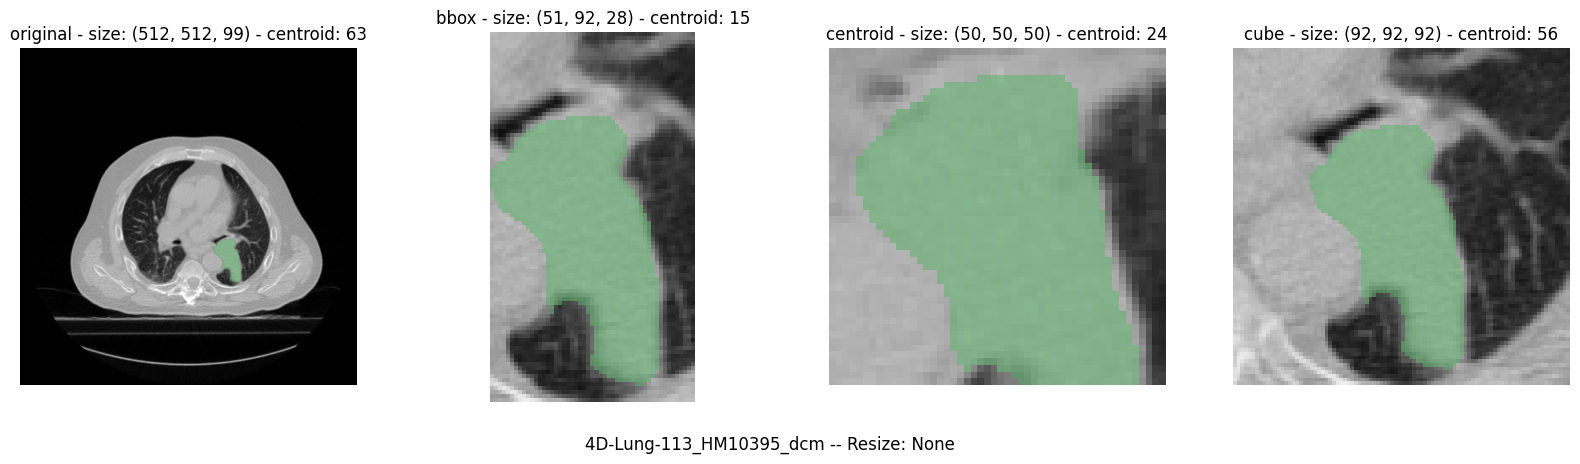

In [15]:
def plotSliceOnAxis(axis, img_slice, vmin, vmax, cmap=plt.cm.Greys_r):
    axis.imshow(img_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    axis.set_axis_off()
    return axis


figure, axis = plt.subplots(1,4)
figure.set_figwidth(20)
cmap=plt.cm.Greys_r
# range values taken from cube crop image
disp_min = -1000
disp_max = 755

crop_images = {"original": image,
               "bbox": bbox_image, 
               "centroid": centroid_image, 
               "cube": cube_image}

crop_masks = {"original": mask,
              "bbox": bbox_mask, 
              "centroid": centroid_mask, 
              "cube": cube_mask}


for idx, crop_type in enumerate(crop_images):
    selected_image = crop_images[crop_type]
    selected_mask = crop_masks[crop_type]

    # Get slice index from centroid of mask
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(selected_mask)
    centroid = stats.GetCentroid(1)
    centroid_idx = selected_mask.TransformPhysicalPointToIndex(centroid)
    
    # Get the image slice
    arr_image = sitk.GetArrayFromImage(selected_image)
    slice_idx = centroid_idx[2]
    img_slice = arr_image[slice_idx,:,:]
    
    # Plot the slice on the axis
    plotSliceOnAxis(axis[idx], img_slice=img_slice, vmin=disp_min, vmax=disp_max, cmap=cmap)

    # Plot the segmentation mask as overlay
    arr_mask = sitk.GetArrayFromImage(selected_mask)
    bin_mask = np.ma.masked_where(arr_mask==0, arr_mask) 

    axis[idx].imshow(bin_mask[slice_idx, :, :], cmap=plt.cm.Greens, vmin=disp_min, vmax=disp_max, alpha=0.5)
    axis[idx].set_title(f"{crop_type} - size: {selected_image.GetSize()} - centroid: {slice_idx}")

plt.figtext(0.5, 0.01, f"{sample} -- Resize: {resize_dimension}", horizontalalignment='center', fontsize=12)
plt.savefig(f"TRASH/crop_figs/{sample}_all_crops_resize_{resize_dimension}.png")


### Trying out different mask casting methods

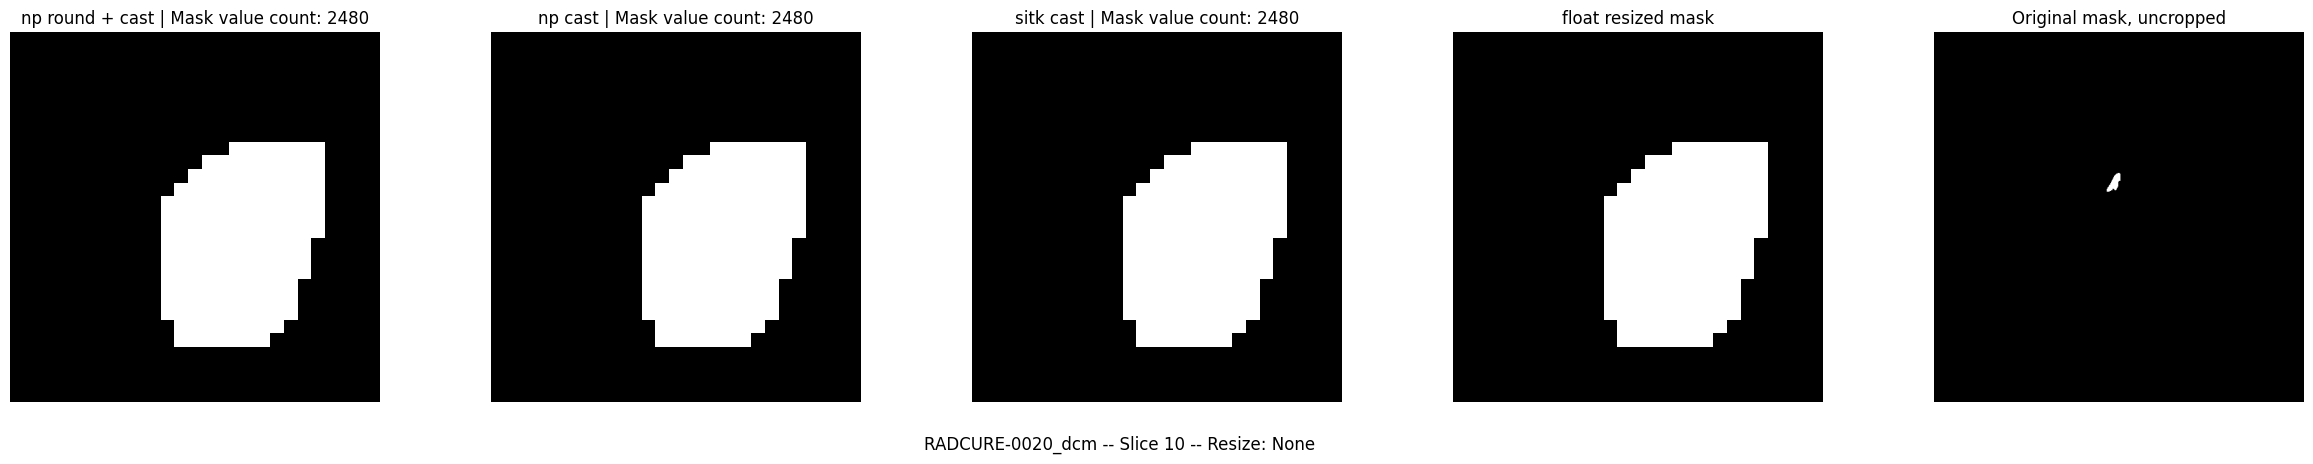

In [93]:
crop_slice_idx = 10

fig, ax = plt.subplots(1, 5)
fig.set_figwidth(30)

# Handling mask conversion from float to int
ax_mask = displayImageSlice(mask, sliceIdx=60, sliceDim='first', ax=ax[4])
ax[4].set_title(f"Original mask, uncropped")
ax_cube_mask = displayImageSlice(cube_mask, sliceIdx=crop_slice_idx, sliceDim='first', ax=ax[3])
ax[3].set_title(f"float resized mask")


# Approach #1 = convert to numpy array, round, then cast to int
arr_cube_mask = sitk.GetArrayFromImage(cube_mask)
arr_converted_mask_round = np.round(arr_cube_mask).astype(int)
arr_converted_mask_round_ax = displayImageSlice(arr_converted_mask_round, sliceIdx=crop_slice_idx, sliceDim='first', ax=ax[0])
ax[0].set_title(f"np round + cast | Mask value count: {np.sum(arr_converted_mask_round)}")

# Approach #2 = convert to numpy array, cast to int 
int_arr_cube_mask = arr_cube_mask.astype(int)
int_arr_cube_mask_ax = displayImageSlice(int_arr_cube_mask, sliceIdx=crop_slice_idx, sliceDim='first', ax=ax[1])
ax[1].set_title(f"np cast | Mask value count: {np.sum(int_arr_cube_mask)}")

# Approach #3 = cast sitk image to sitkUInt8
cast_mask = sitk.Cast(cube_mask, sitk.sitkUInt8)
cast_mask_ax = displayImageSlice(cast_mask, sliceIdx=crop_slice_idx, sliceDim='first', ax=ax[2])
ax[2].set_title(f"sitk cast | Mask value count: {np.sum(sitk.GetArrayFromImage(cast_mask))}")

title = plt.figtext(0.5, 0.01, f"{sample} -- Slice {crop_slice_idx} -- Resize: {resize_dimension}", ha="center", fontsize=12)

fig.savefig(f"TRASH/crop_figs/{sample}_mask_slice_{crop_slice_idx}_resize_{resize_dimension}.png")

### Looking at different interpolation methods for resizing/resampling

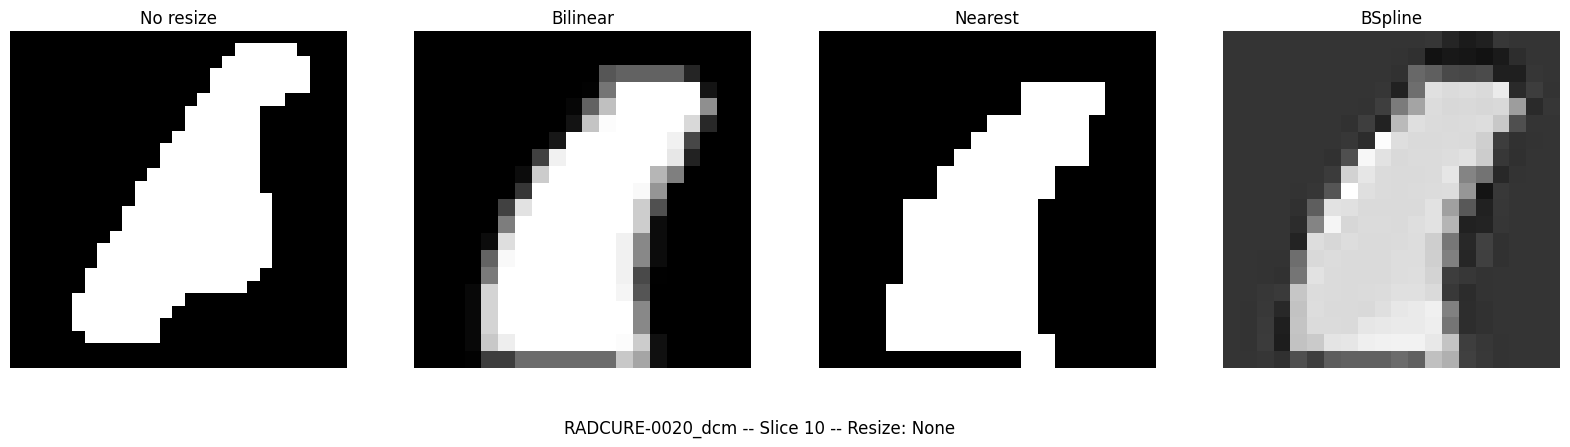

In [96]:
from imgtools.ops.functional import resize

resize_size = 20
resize_slice_idx = 13

resize_fig, resize_ax = plt.subplots(1, 4)
resize_fig.set_figwidth(20)

ax_cube_mask = displayImageSlice(cube_mask, sliceIdx=15, sliceDim='first', ax=resize_ax[0])
resize_ax[0].set_title(f"No resize")

resize_bilinear = resize(cube_mask, size=resize_size, interpolation="linear")
bilinear_ax = displayImageSlice(resize_bilinear, sliceIdx=resize_slice_idx, sliceDim='first', ax=resize_ax[1])
resize_ax[1].set_title(f"Bilinear")

resize_nearest = resize(cube_mask, size=resize_size, interpolation="nearest")
nearest_ax = displayImageSlice(resize_nearest, sliceIdx=resize_slice_idx, sliceDim='first', ax=resize_ax[2])
resize_ax[2].set_title(f"Nearest")

resize_bspline = resize(cube_mask, size=resize_size, interpolation="bspline")
bspline_ax = displayImageSlice(resize_bspline, sliceIdx=resize_slice_idx, sliceDim='first', ax=resize_ax[3])
resize_ax[3].set_title(f"BSpline")

title = plt.figtext(0.5, 0.01, f"{sample} -- Slice {crop_slice_idx} -- Resize: {resize_dimension}", ha="center", fontsize=12)

<Axes: >

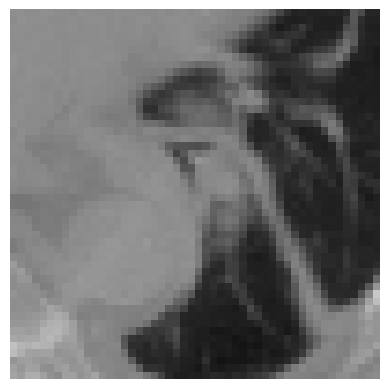

In [16]:
displayImageSlice(cube_image, sliceIdx=crop_slice_idx)

In [66]:
cube_mask.GetSize()

(99, 99, 99)

In [100]:
np.unique(sitk.GetArrayFromImage(resize_nearest)).astype(int)

array([0, 1])